
# Classifiation of Silhouettes Vehicle Project

The purpose of the case study is to classify a given silhouette as one of four different types of vehicle, using a set of features extracted from the silhouette. The vehicle may be viewed from one of many different angles.

Four "Corgie" model vehicles were used for the experiment: a double decker bus, Cheverolet van, Saab 9000 and an Opel Manta 400 cars. This particular combination of vehicles was chosen with the expectation that the bus, van and either one of the cars would be readily distinguishable, but it would be more difficult to distinguish between the cars.

The purpose is to classify a given silhouette as one of three types of vehicle, using a set of features extracted from the silhouette. The vehicle may be viewed from one of many different angles.

**Attribute Information**

* `compactness`: (average perim)^2/area
* `circularity`: (average radius)^2/area
* `distance_circularity`: area/(av.distance from border)^2
* `radius_ratio`: (max.rad-min.rad)/av.radius
* `pr.axis_aspect_ratio`: (minor axis)/(major axis)
* `max.length_aspect_ratio`: (length perp. max length)/(max length)
* `scatter_ratio`: (inertia about minor axis)/(inertia about major axis)
* `elongatedness`: area/(shrink width)^2
* `pr.axis_rectangularity`: area/(pr.axis length*pr.axis width)
* `max.length_rectangularity`: area/(max.length*length perp. to this)
* `scaled_variance`: (2nd order moment about minor axis)/area along major axis
* `scaled_variance.1`: (2nd order moment about major axis)/area along minor axis
* `scaled_radius_of_gyration`: (mavar+mivar)/area
* `scaled_radius_of_gyration.1`
* `skewness_about`: (3rd order moment about major axis)/sigma_min^3 major axis
* `skewness_about.1`: (3rd order moment about minor axis)/sigma_maj^3 minor axis
* `skewness_about.2`
* `hollows_ratio`: (area of hollows)/(area of bounding polygon)
* `class`: van, car, bus

Where sigma_maj^2 is the variance along the major axis and sigma_min^2 is the variance along the minor axis, and area of hollows = area of bounding poly-area of object

The area of the bounding polygon is found as a side result of the computation to find the maximum length. Each individual length computation yields a pair of calipers to the object orientated at every 5 degrees. The object is propagated into an image containing the union of these calipers to obtain an image of the bounding polygon.

**Learning Outcomes**
1. **Data pre-processing** - Understand the data and treat missing values (Use box plot), outliers
2. **Understanding the attributes** - Find relationship between different attributes (Independent variables) and choose carefully which all attributes have to be a part of the analysis and why
3. **Use PCA** from scikit learn and elbow plot to find out reduced number of dimension (which covers more than 95% of the variance)
4. **Use Naive Bayes and Support Vector Classifier**. Use grid search for SVC (try C values - 0.01, 0.05, 0.5, 1 and kernel = linear, rbf) and find out the best hyper parameters and do cross validation to find the accuracy.

<a id='packages'></a>
### Import Packages

In [2]:
# Basic packages
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, gc
from scipy import stats; from scipy.stats import zscore, norm, randint
import matplotlib.style as style; style.use('fivethirtyeight')
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
%matplotlib inline

# Models
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Display settings
pd.options.display.max_rows = 400
pd.options.display.max_columns = 100
pd.options.display.float_format = "{:.2f}".format

random_state = 42
np.random.seed(random_state)

# Suppress warnings
import warnings; warnings.filterwarnings('ignore')

<a id='reading'></a>
### Reading the data as a dataframe and print the first fifteen rows

In [3]:
# Reading the data as dataframe and print the first fifteen rows
vehicle = pd.read_csv('vehicle.csv')
vehicle.head(15)

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
0,95,48.00,83.00,178.00,72.00,10,162.00,42.00,20.00,159,176.00,379.00,184.00,70.00,6.00,16.00,187.00,197,van
1,91,41.00,84.00,141.00,57.00,9,149.00,45.00,19.00,143,170.00,330.00,158.00,72.00,9.00,14.00,189.00,199,van
2,104,50.00,106.00,209.00,66.00,10,207.00,32.00,23.00,158,223.00,635.00,220.00,73.00,14.00,9.00,188.00,196,car
3,93,41.00,82.00,159.00,63.00,9,144.00,46.00,19.00,143,160.00,309.00,127.00,63.00,6.00,10.00,199.00,207,van
4,85,44.00,70.00,205.00,103.00,52,149.00,45.00,19.00,144,241.00,325.00,188.00,127.00,9.00,11.00,180.00,183,bus
5,107,NaN,106.00,172.00,50.00,6,255.00,26.00,28.00,169,280.00,957.00,264.00,85.00,5.00,9.00,181.00,183,bus
6,97,43.00,73.00,173.00,65.00,6,153.00,42.00,19.00,143,176.00,361.00,172.00,66.00,13.00,1.00,200.00,204,bus
7,90,43.00,66.00,157.00,65.00,9,137.00,48.00,18.00,146,162.00,281.00,164.00,67.00,3.00,3.00,193.00,202,van
8,86,34.00,62.00,140.00,61.00,7,122.00,54.00,17.00,127,141.00,223.00,112.00,64.00,2.00,14.00,200.00,208,van
9,93,44.00,98.00,NaN,62.00,11,183.00,36.00,22.00,146,202.00,505.00,152.00,64.00,4.00,14.00,195.00,204,car


In [3]:
vehicle.columns

Index(['compactness', 'circularity', 'distance_circularity', 'radius_ratio',
       'pr.axis_aspect_ratio', 'max.length_aspect_ratio', 'scatter_ratio',
       'elongatedness', 'pr.axis_rectangularity', 'max.length_rectangularity',
       'scaled_variance', 'scaled_variance.1', 'scaled_radius_of_gyration',
       'scaled_radius_of_gyration.1', 'skewness_about', 'skewness_about.1',
       'skewness_about.2', 'hollows_ratio', 'class'],
      dtype='object')

<a id='info'></a>
### Get info of the dataframe columns and check missing values

In [4]:
# Get info of the dataframe columns
vehicle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   compactness                  846 non-null    int64  
 1   circularity                  841 non-null    float64
 2   distance_circularity         842 non-null    float64
 3   radius_ratio                 840 non-null    float64
 4   pr.axis_aspect_ratio         844 non-null    float64
 5   max.length_aspect_ratio      846 non-null    int64  
 6   scatter_ratio                845 non-null    float64
 7   elongatedness                845 non-null    float64
 8   pr.axis_rectangularity       843 non-null    float64
 9   max.length_rectangularity    846 non-null    int64  
 10  scaled_variance              843 non-null    float64
 11  scaled_variance.1            844 non-null    float64
 12  scaled_radius_of_gyration    844 non-null    float64
 13  scaled_radius_of_gyr

<a id='o1'></a>
#### Observation 1 - Dataset shape
Dataset has 846 rows and 19 columns with missing values in several columns. Checking those..

In [5]:
# Checking missing values in dataframe
vehicle.isnull().sum()

compactness                    0
circularity                    5
distance_circularity           4
radius_ratio                   6
pr.axis_aspect_ratio           2
max.length_aspect_ratio        0
scatter_ratio                  1
elongatedness                  1
pr.axis_rectangularity         3
max.length_rectangularity      0
scaled_variance                3
scaled_variance.1              2
scaled_radius_of_gyration      2
scaled_radius_of_gyration.1    4
skewness_about                 6
skewness_about.1               1
skewness_about.2               1
hollows_ratio                  0
class                          0
dtype: int64

<a id='eda'></a>
## Exploratory Data Analysis
Performing exploratory data analysis on the bank dataset. Below are some of the steps performed:

* Get descriptive statistics including five point summary
* Comment on the types of variables in dataset and descriptive statistics observation
* Check unique values in `class` columns
* Check distribution of `class` column
* Check missing values in the dataframe and impute those missing values
* Univariate and Bivariate visualization: Looking at one feature at a time to understand how are the values are distributed, checking outliers and relation of the columns with `class`
* Handle outliers using SimpleImputer
* Multivariate visualization including correlation and scatterplot matrix. In the process identify the features to be taken further for the study

<a id='5point'></a>
### Five point summary of numerical attributes and check unique values in 'object' columns

In [6]:
# Five point summary
vehicle.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
compactness,846.00,NaN,NaN,NaN,93.68,8.23,73.00,87.00,93.00,100.00,119.00
circularity,841.00,NaN,NaN,NaN,44.83,6.15,33.00,40.00,44.00,49.00,59.00
distance_circularity,842.00,NaN,NaN,NaN,82.11,15.78,40.00,70.00,80.00,98.00,112.00
radius_ratio,840.00,NaN,NaN,NaN,168.89,33.52,104.00,141.00,167.00,195.00,333.00
pr.axis_aspect_ratio,844.00,NaN,NaN,NaN,61.68,7.89,47.00,57.00,61.00,65.00,138.00
max.length_aspect_ratio,846.00,NaN,NaN,NaN,8.57,4.60,2.00,7.00,8.00,10.00,55.00
scatter_ratio,845.00,NaN,NaN,NaN,168.90,33.21,112.00,147.00,157.00,198.00,265.00
elongatedness,845.00,NaN,NaN,NaN,40.93,7.82,26.00,33.00,43.00,46.00,61.00
pr.axis_rectangularity,843.00,NaN,NaN,NaN,20.58,2.59,17.00,19.00,20.00,23.00,29.00
max.length_rectangularity,846.00,NaN,NaN,NaN,148.00,14.52,118.00,137.00,146.00,159.00,188.00


<a id='o2'></a>
#### Observation 2 - information on the type of variable

`compactness`, `max.length_aspect_ratio`, `max.length_rectangularity`, `hollows_ratio`, `class` has no missing values, rest all features don't have any missing values. All features are of numerical types. `class` is a target variable and has three unique values.
    
<a id='o3'></a>
#### Observation 3 - Descriptive statistics for the numerical variables
Descriptive statistics for the numerical variables
* **`compactness`**: Range of Q1 to Q3 is between 87 to 100. It appears that the column is almost normally distributed.

* **`circularity`**: Range of Q1 to Q3 is 40 to 49. This column too appears to be almost normally distributed.

* **`distance_circularity`**: Range of Q1 to Q3 is 70 to 98. Mean is slightly greater than median, we can say that the column is slightly skewed towards right.

* **`radius_ratio`**: Range of Q1 to Q3 is 141 to 195. Mean is slightly greater than median, we can say that the column is slightly skewed towards right.

* **`pr.axis_aspect_ratio`**: Range of Q1 to Q3 is 57 to 65. Mean is slightly greater than median, we can say that the column is slightly skewed towards right.

* **`max.length_aspect_ratio`**: Range of Q1 to Q3 is 7 to 10. Mean is slightly greater than median, we can say that the column is slightly skewed towards right.

* **`scatter_ratio`**: Range of Q1 to Q3 is 147 to 198. Mean is greater than median, we can say that the column is skewed towards right.

* **`elongatedness`**: Range of Q1 to Q3 is 33 to 46. Mean is less than median, we can say that the column is skewed towards left.

* **`pr.axis_rectangularity`**: Range of Q1 to Q3 is 19 to 23. Mean is greater than median, we can say that the column is skewed towards right.

* **`max.length_rectangularity`**: Range of Q1 to Q3 is 137 to 159. Mean is greater than median, we can say that the column is skewed towards right.

* **`scaled_variance`**: Range of Q1 to Q3 is 167 to 217. Mean is grater than median, we can say that the column is skewed towards right.

* **`scaled_variance.1`**: Range of Q1 to Q3 is 318 to 587. Mean is greater than median, we can say that the column is skewed towards right.

* **`scaled_radius_of_gyration`**: Range of Q1 to Q3 is 149 to 198. Mean is greater than median, we can say that the column is skewed towards right.

* **`scaled_radius_of_gyration.1`**: Range of Q1 to Q3 is 67 to 75. Mean is greater than median, we can say that the column is skewed towards right.

* **`skewness_about`**: Range of Q1 to Q3 is 2 to 6. Mean is greater than median, skewed towards right.

* **`skewness_about.1`**: Range of Q1 to Q3 is 5 to 19. Mean is greater than median, skewed towards right.

* **`skewness_about.2`**: Range of Q1 to Q3 is 184 to 193. Mean is slightly greater than median, almost normally distributed.

* **`hollows_ratio`**: Range of Q1 to Q3 is 197 to 211. Mean is less than median, skewed towards left.

In [7]:
columns = vehicle.loc[:, vehicle.dtypes == 'object'].columns.tolist()
for cols in columns:
    print(f'Unique values for {cols} is \n{vehicle[cols].unique()}\n')
del cols, columns

Unique values for class is 
['van' 'car' 'bus']



<a id='target'></a>
### Checking the distribution of class variable

In [8]:
display(vehicle['class'].value_counts(), vehicle['class'].value_counts(normalize = True)*100)

car    429
bus    218
van    199
Name: class, dtype: int64

car   50.71
bus   25.77
van   23.52
Name: class, dtype: float64

In [9]:
replace_struc = {'car': 3, 'bus': 2, 'van': 1}
vehicle['class'] = vehicle['class'].map(replace_struc)
del replace_struc

<a id='o4'></a>
#### Observation 4 - Distribution of class variable
`car` represents about 50.7% of the total values in class variable, `bus` about 25.8% and `van` about 23.5%.

In [10]:
# Check missing values in the dataframe
vehicle.isnull().sum()

compactness                    0
circularity                    5
distance_circularity           4
radius_ratio                   6
pr.axis_aspect_ratio           2
max.length_aspect_ratio        0
scatter_ratio                  1
elongatedness                  1
pr.axis_rectangularity         3
max.length_rectangularity      0
scaled_variance                3
scaled_variance.1              2
scaled_radius_of_gyration      2
scaled_radius_of_gyration.1    4
skewness_about                 6
skewness_about.1               1
skewness_about.2               1
hollows_ratio                  0
class                          0
dtype: int64

In [11]:
null_columns = vehicle.columns[vehicle.isnull().any()]; columns = list(vehicle.columns)

print('Descriptive Stats before imputation for columns with missing values: \n', '--'*30)
display(vehicle[null_columns].describe().T)

# Using SimpleImputer to fill missing values by median
impute = SimpleImputer(missing_values = np.nan, strategy = 'median', verbose = 1)
vehicle = pd.DataFrame(impute.fit_transform(vehicle), columns = columns)

print('Descriptive Stats after imputation: \n', '--'*30)
display(vehicle[null_columns].describe().T)

del null_columns

Descriptive Stats before imputation for columns with missing values: 
 ------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
circularity,841.00,44.83,6.15,33.00,40.00,44.00,49.00,59.00
distance_circularity,842.00,82.11,15.78,40.00,70.00,80.00,98.00,112.00
radius_ratio,840.00,168.89,33.52,104.00,141.00,167.00,195.00,333.00
pr.axis_aspect_ratio,844.00,61.68,7.89,47.00,57.00,61.00,65.00,138.00
scatter_ratio,845.00,168.90,33.21,112.00,147.00,157.00,198.00,265.00
elongatedness,845.00,40.93,7.82,26.00,33.00,43.00,46.00,61.00
pr.axis_rectangularity,843.00,20.58,2.59,17.00,19.00,20.00,23.00,29.00
scaled_variance,843.00,188.63,31.41,130.00,167.00,179.00,217.00,320.00
scaled_variance.1,844.00,439.49,176.67,184.00,318.00,363.50,587.00,1018.00
scaled_radius_of_gyration,844.00,174.71,32.58,109.00,149.00,173.50,198.00,268.00


Descriptive Stats after imputation: 
 ------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
circularity,846.00,44.82,6.13,33.00,40.00,44.00,49.00,59.00
distance_circularity,846.00,82.10,15.74,40.00,70.00,80.00,98.00,112.00
radius_ratio,846.00,168.87,33.40,104.00,141.00,167.00,195.00,333.00
pr.axis_aspect_ratio,846.00,61.68,7.88,47.00,57.00,61.00,65.00,138.00
scatter_ratio,846.00,168.89,33.20,112.00,147.00,157.00,198.00,265.00
elongatedness,846.00,40.94,7.81,26.00,33.00,43.00,46.00,61.00
pr.axis_rectangularity,846.00,20.58,2.59,17.00,19.00,20.00,23.00,29.00
scaled_variance,846.00,188.60,31.36,130.00,167.00,179.00,217.00,320.00
scaled_variance.1,846.00,439.31,176.50,184.00,318.25,363.50,586.75,1018.00
scaled_radius_of_gyration,846.00,174.71,32.55,109.00,149.00,173.50,198.00,268.00


<a id='impute'></a>
#### Observation 5 - After imputation
A quick observation after imputating the missing values: medians remain unchanged while mean changes slightly not significantly. Type of skewness remain unchanged.

In [12]:
# Functions that will help us with EDA plot
def odp_plots(df, col):
    f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 7.2))
    
    # Boxplot to check outliers
    sns.boxplot(x = col, data = df, ax = ax1, orient = 'v', color = 'darkslategrey')
    
    # Distribution plot with outliers
    sns.distplot(df[col], ax = ax2, color = 'teal', fit = norm).set_title(f'{col} with outliers')
    
    # Removing outliers, but in a new dataframe
    upperbound, lowerbound = np.percentile(df[col], [1, 99])
    y = pd.DataFrame(np.clip(df[col], upperbound, lowerbound))
    
    # Distribution plot without outliers
    sns.distplot(y[col], ax = ax3, color = 'tab:orange', fit = norm).set_title(f'{col} without outliers')
    
    kwargs = {'fontsize':14, 'color':'black'}
    ax1.set_title(col + ' Boxplot Analysis', **kwargs)
    ax1.set_xlabel('Box', **kwargs)
    ax1.set_ylabel(col + ' Values', **kwargs)

    return plt.show()

# function for ploting distribution of variables with target
def target_plot(df, col1, col2, col3, target = 'class'):
    f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 7.2))
    f.suptitle(f'Distribution for Car, Bus, Van for {col1.capitalize()}, {col2.capitalize()}, {col3.capitalize()}', 
               fontsize = 14)
    # Distribution for col1 considering outliers
    sns.distplot(df[(df[target] == 3)][col1], color = 'c', ax = ax1, hist = False, 
                 label = 'Car').set_title(f'{col1.capitalize()}')
    sns.distplot(df[(df[target] == 2)][col1], color = 'b', ax = ax1, hist = False, 
                 label = 'Bus').set_title(f'{col1.capitalize()}')
    sns.distplot(df[(df[target] == 1)][col1], color = 'm', ax = ax1, hist = False, 
                 label = 'Van').set_title(f'{col1.capitalize()}')

    # Distribution for col2 considering outliers
    sns.distplot(df[(df[target] == 3)][col2], color = 'c', ax = ax2, hist = False, 
                 label = 'Car').set_title(f'{col2.capitalize()}')
    sns.distplot(df[(df[target] == 2)][col2], color = 'b', ax = ax2, hist = False, 
                 label = 'Bus').set_title(f'{col2.capitalize()}')
    sns.distplot(df[(df[target] == 1)][col2], color = 'm', ax = ax2, hist = False, 
                 label = 'Van').set_title(f'{col2.capitalize()}')

    # Distribution for col3 considering outliers
    sns.distplot(df[(df[target] == 3)][col3], color = 'c', ax = ax3, hist = False, 
                 label = 'Car').set_title(f'{col3.capitalize()}')
    sns.distplot(df[(df[target] == 2)][col3], color = 'b', ax = ax3, hist = False, 
                 label = 'Bus').set_title(f'{col3.capitalize()}')
    sns.distplot(df[(df[target] == 1)][col3], color = 'm', ax = ax3, hist = False, 
                 label = 'Van').set_title(f'{col3.capitalize()}')
    return plt.show()

# Correlation matrix for all variables
def correlation_matrix(df, threshold = 0.8):
    corr = df.corr()
    mask = np.zeros_like(corr, dtype = np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize = (15, 7.2))
    cmap = sns.diverging_palette(220, 10, as_cmap = True)
    sns.heatmap(corr, mask = mask, cmap = cmap, square = True, linewidths = .5, cbar_kws = {"shrink": .5})#, annot = True)
    ax.set_title('Correlation Matrix of Data')

    # Filter for correlation value greater than threshold
    sort = corr.abs().unstack()
    sort = sort.sort_values(kind = "quicksort", ascending = False)
    display(sort[(sort > threshold) & (sort < 1)])

# Helper function for PCA plots
def pca_plots(df, col1, col2, xlabel, ylabel, ax):
    ax.set_xlabel(xlabel); ax.set_ylabel(ylabel)
    ax.set_title(f'{xlabel} vs {ylabel}', fontsize = 14)
    targets = [3, 2, 1]; colors = ['r', 'g', 'b']
    for target, color in zip(targets, colors):
        indicesToKeep = df['class'] == target
        ax.scatter(df.loc[indicesToKeep, col1], df.loc[indicesToKeep, col2], c = color, s = 50)
    ax.legend(targets)

# Helper function to plot learning curve
def plot_learning_curve(estimator, X, y,  ax, ylim = None, cv = None, n_jobs = 1,
                        train_sizes = np.linspace(.1, 1.0, 5), name = 'Naive Bayes \n Principal Compoents Learning Curve'):    
    if ylim is not None:
        plt.ylim(*ylim)
        
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv = cv, n_jobs = n_jobs, 
                                                            train_sizes = train_sizes)
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                     alpha = 0.1, color = '#ff9124')
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                     alpha = 0.1, color = '#2492ff')

    ax.plot(train_sizes, train_scores_mean, 'o-', color = '#ff9124', label = 'Training score')
    ax.plot(train_sizes, test_scores_mean, 'o-', color ='#2492ff', label = 'Cross-validation score')
    ax.set_title(name, fontsize = 14)
    ax.set_xlabel('Training size')
    ax.set_ylabel('Score')
    ax.grid(True)
    ax.legend(loc = 'best')

<a id='unibi'></a>
### Univariate and Bivariate Visualization
Looking at one feature at a time to understand how are the values distributed, checking outliers, checking relation of the column with `class` column (bi).

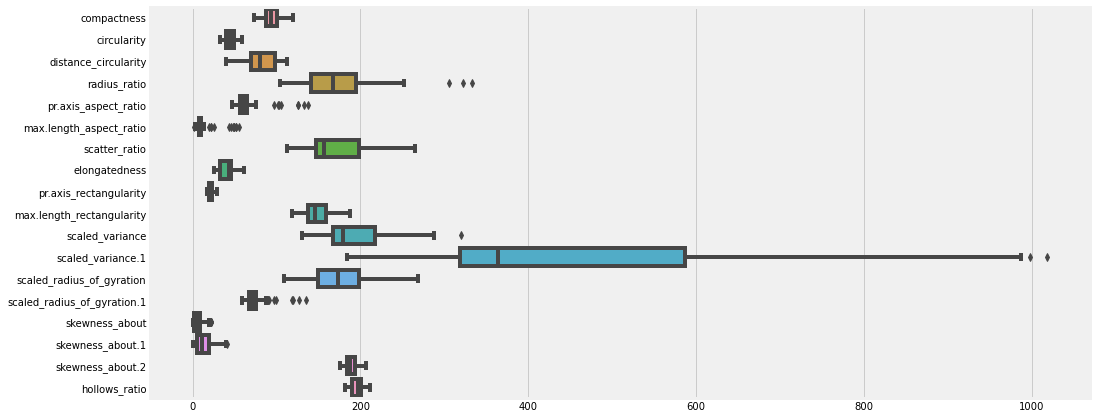

In [13]:
# A quick check to find columns that contain outliers
fig = plt.figure(figsize = (15, 7.2))
ax = sns.boxplot(data = vehicle.iloc[:, 0:18], orient = 'h')

Radius_ratio column --------------------------------------------------------------------------------


3

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
37,90.00,48.00,86.00,306.00,126.00,49.00,153.00,44.00,19.00,156.00,272.00,346.00,200.00,118.00,0.00,15.00,185.00,194.00,1.00
135,89.00,47.00,83.00,322.00,133.00,48.00,158.00,43.00,20.00,163.00,229.00,364.00,176.00,97.00,0.00,14.00,184.00,194.00,1.00
388,94.00,47.00,85.00,333.00,138.00,49.00,155.00,43.00,19.00,155.00,320.00,354.00,187.00,135.00,12.00,9.00,188.00,196.00,1.00


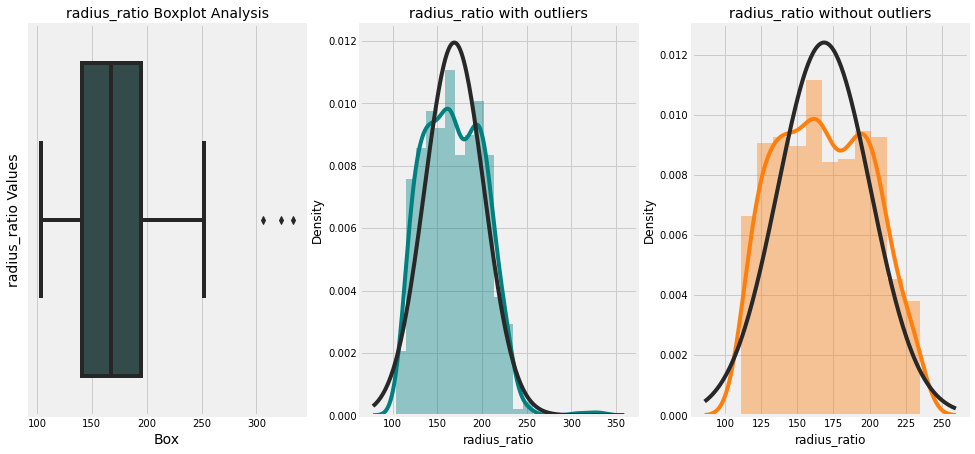

Pr.axis_aspect_ratio column --------------------------------------------------------------------------------


8

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
4,85.00,44.00,70.00,205.00,103.00,52.00,149.00,45.00,19.00,144.00,241.00,325.00,188.00,127.00,9.00,11.00,180.00,183.00,2.00
37,90.00,48.00,86.00,306.00,126.00,49.00,153.00,44.00,19.00,156.00,272.00,346.00,200.00,118.00,0.00,15.00,185.00,194.00,1.00
100,82.00,45.00,66.00,252.00,126.00,52.00,148.00,45.00,19.00,144.00,237.00,326.00,185.00,119.00,1.00,1.00,181.00,185.00,2.00
135,89.00,47.00,83.00,322.00,133.00,48.00,158.00,43.00,20.00,163.00,229.00,364.00,176.00,97.00,0.00,14.00,184.00,194.00,1.00
291,89.00,45.00,81.00,246.00,102.00,43.00,155.00,44.00,20.00,160.00,200.00,347.00,177.00,90.00,9.00,17.00,183.00,192.00,1.00


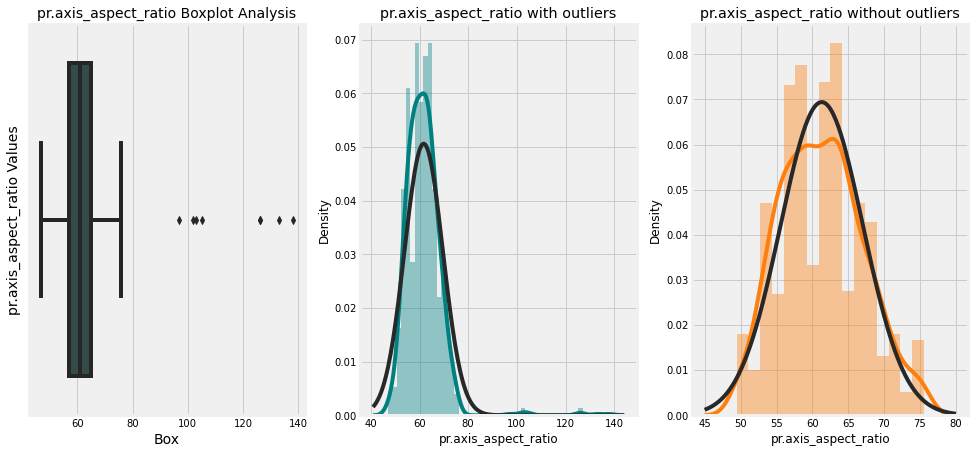

Max.length_aspect_ratio column --------------------------------------------------------------------------------


13

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
4,85.00,44.00,70.00,205.00,103.00,52.00,149.00,45.00,19.00,144.00,241.00,325.00,188.00,127.00,9.00,11.00,180.00,183.00,2.00
37,90.00,48.00,86.00,306.00,126.00,49.00,153.00,44.00,19.00,156.00,272.00,346.00,200.00,118.00,0.00,15.00,185.00,194.00,1.00
100,82.00,45.00,66.00,252.00,126.00,52.00,148.00,45.00,19.00,144.00,237.00,326.00,185.00,119.00,1.00,1.00,181.00,185.00,2.00
127,85.00,41.00,66.00,155.00,65.00,22.00,149.00,45.00,19.00,139.00,173.00,330.00,155.00,75.00,6.00,16.00,184.00,191.00,2.00
135,89.00,47.00,83.00,322.00,133.00,48.00,158.00,43.00,20.00,163.00,229.00,364.00,176.00,97.00,0.00,14.00,184.00,194.00,1.00


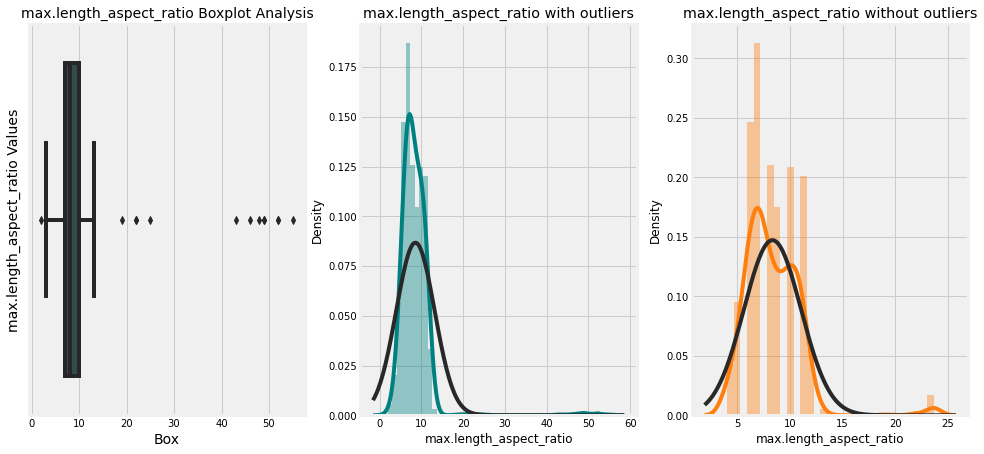

Scaled_variance column --------------------------------------------------------------------------------


1

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
388,94.00,47.00,85.00,333.00,138.00,49.00,155.00,43.00,19.00,155.00,320.00,354.00,187.00,135.00,12.00,9.00,188.00,196.00,1.00


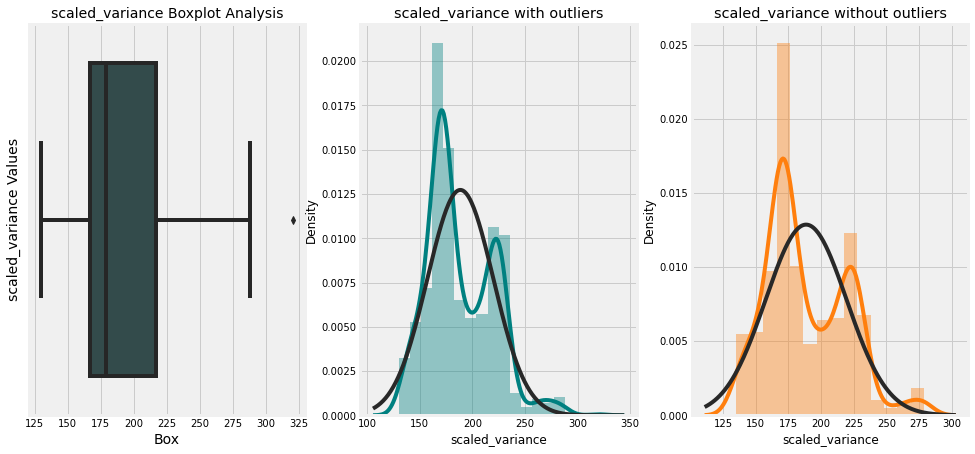

Scaled_variance.1 column --------------------------------------------------------------------------------


2

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
85,110.00,58.00,106.00,180.00,51.00,6.00,261.00,26.00,28.00,171.00,278.00,998.00,257.00,83.00,9.00,13.00,181.00,182.00,2.00
835,111.00,58.00,105.00,183.00,51.00,6.00,265.00,26.00,29.00,174.00,285.00,1018.00,255.00,85.00,4.00,8.00,181.00,183.00,2.00


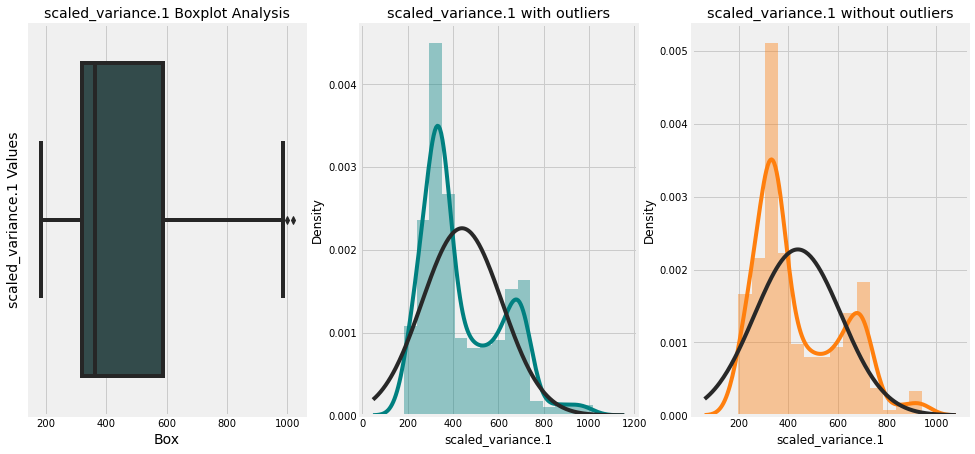

Scaled_radius_of_gyration.1 column --------------------------------------------------------------------------------


15

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
4,85.00,44.00,70.00,205.00,103.00,52.00,149.00,45.00,19.00,144.00,241.00,325.00,188.00,127.00,9.00,11.00,180.00,183.00,2.00
37,90.00,48.00,86.00,306.00,126.00,49.00,153.00,44.00,19.00,156.00,272.00,346.00,200.00,118.00,0.00,15.00,185.00,194.00,1.00
47,85.00,42.00,66.00,122.00,54.00,6.00,148.00,46.00,19.00,141.00,172.00,317.00,174.00,88.00,6.00,14.00,180.00,182.00,2.00
79,89.00,44.00,68.00,113.00,50.00,7.00,150.00,45.00,19.00,147.00,171.00,328.00,189.00,88.00,6.00,5.00,179.00,182.00,2.00
100,82.00,45.00,66.00,252.00,126.00,52.00,148.00,45.00,19.00,144.00,237.00,326.00,185.00,119.00,1.00,1.00,181.00,185.00,2.00


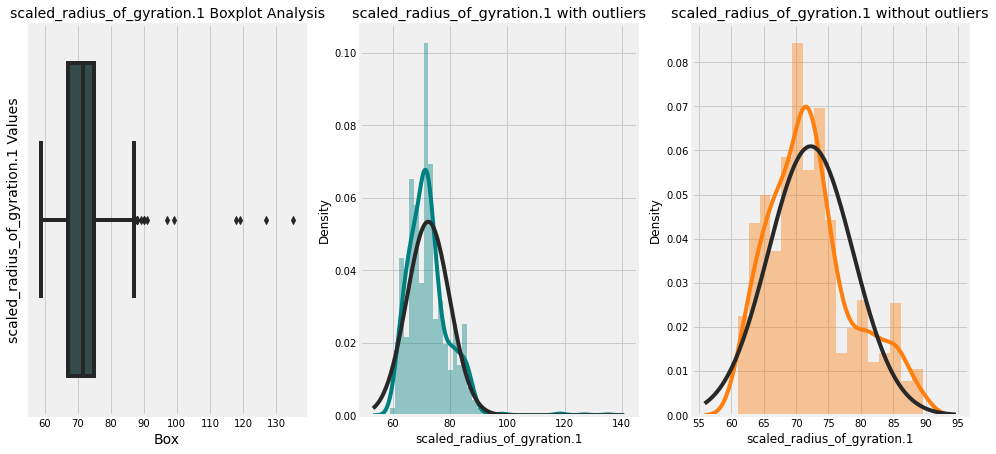

Skewness_about column --------------------------------------------------------------------------------


12

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
44,119.00,54.00,106.00,220.00,65.00,12.00,213.00,31.00,24.00,167.00,223.00,675.00,232.00,66.00,20.00,1.00,192.00,202.00,3.00
113,88.00,35.00,50.00,121.00,58.00,5.00,114.00,59.00,17.00,122.00,132.00,192.00,138.00,74.00,21.00,4.00,182.00,187.00,3.00
123,90.00,36.00,57.00,130.00,57.00,6.00,121.00,56.00,17.00,127.00,137.00,216.00,132.00,68.00,22.00,23.00,190.00,195.00,3.00
190,97.00,48.00,94.00,198.00,63.00,9.00,181.00,36.00,21.00,155.00,200.00,494.00,189.00,64.00,20.00,11.00,199.00,203.00,3.00
346,117.00,52.00,110.00,228.00,65.00,12.00,212.00,31.00,24.00,163.00,228.00,668.00,220.00,66.00,21.00,25.00,194.00,205.00,3.00


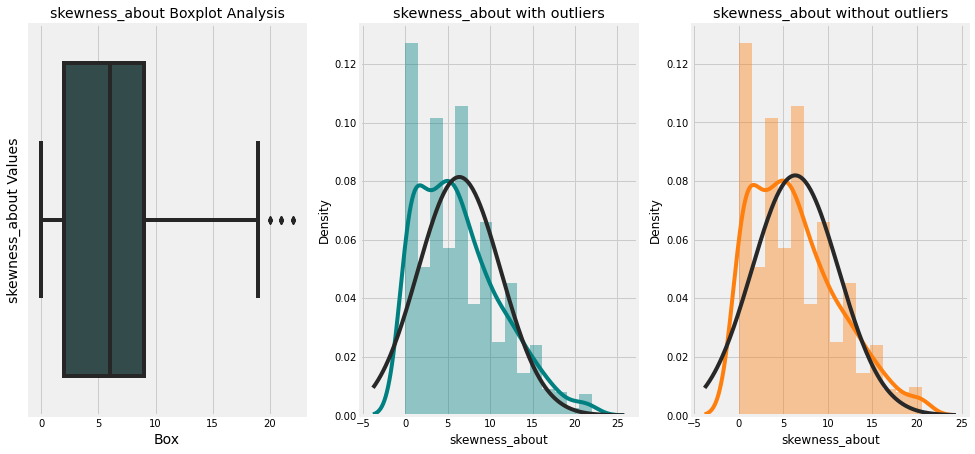

Skewness_about.1 column --------------------------------------------------------------------------------


1

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
132,97.00,42.00,101.00,186.00,59.00,9.00,186.00,36.00,22.00,138.00,208.00,511.00,168.00,67.00,7.00,41.00,194.00,206.00,3.00


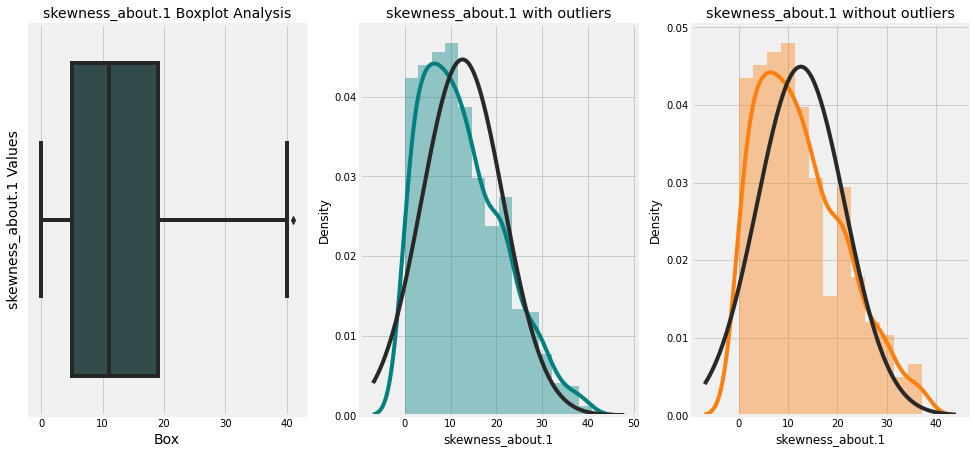

In [14]:
# Outlier, distribution for columns with outliers
boxplotcolumns = ['radius_ratio', 'pr.axis_aspect_ratio', 'max.length_aspect_ratio', 'scaled_variance', 'scaled_variance.1',
                  'scaled_radius_of_gyration.1', 'skewness_about', 'skewness_about.1']
for cols in boxplotcolumns:
    Q3 = vehicle[cols].quantile(0.75)
    Q1 = vehicle[cols].quantile(0.25)
    IQR = Q3 - Q1

    print(f'{cols.capitalize()} column', '--'*40)
    display(len(vehicle.loc[(vehicle[cols] < (Q1 - 1.5 * IQR)) | (vehicle[cols] > (Q3 + 1.5 * IQR))]), 
            vehicle.loc[(vehicle[cols] < (Q1 - 1.5 * IQR)) | (vehicle[cols] > (Q3 + 1.5 * IQR))].head())
    odp_plots(vehicle, cols)

del cols, IQR, boxplotcolumns

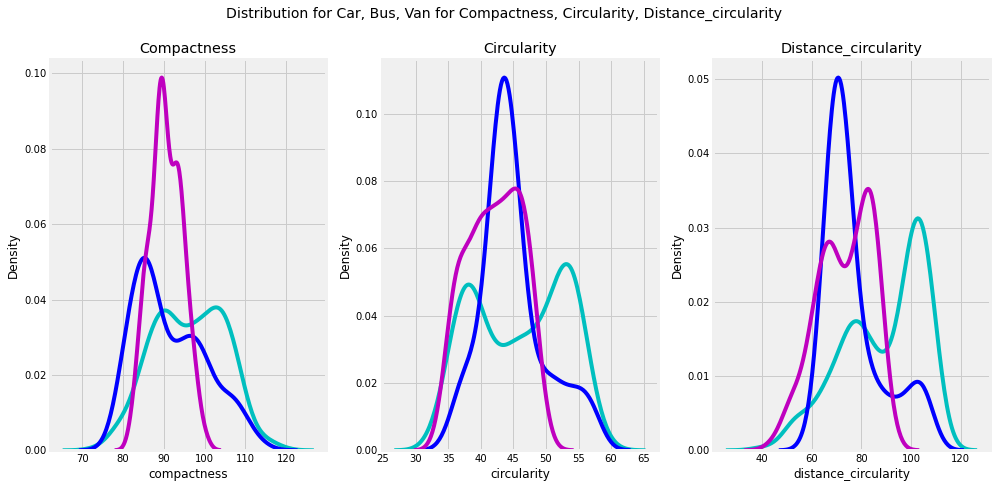

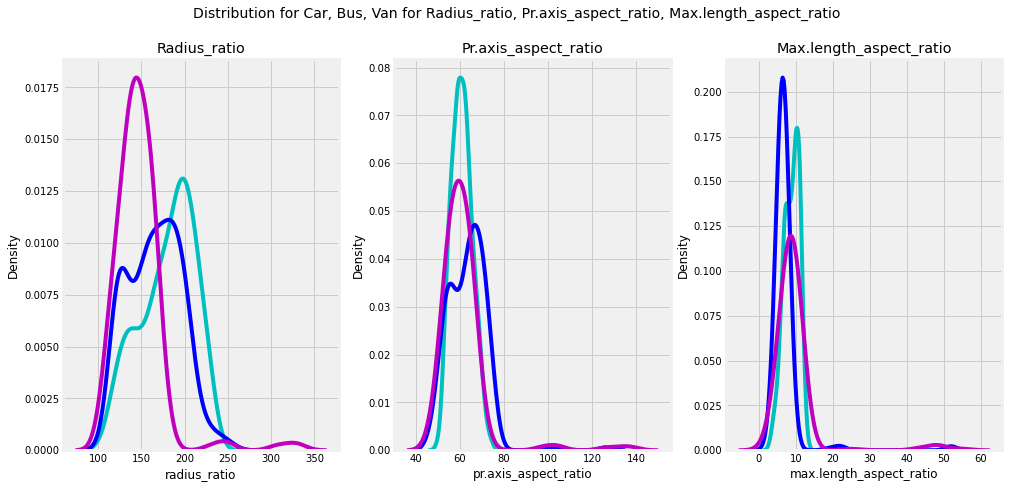

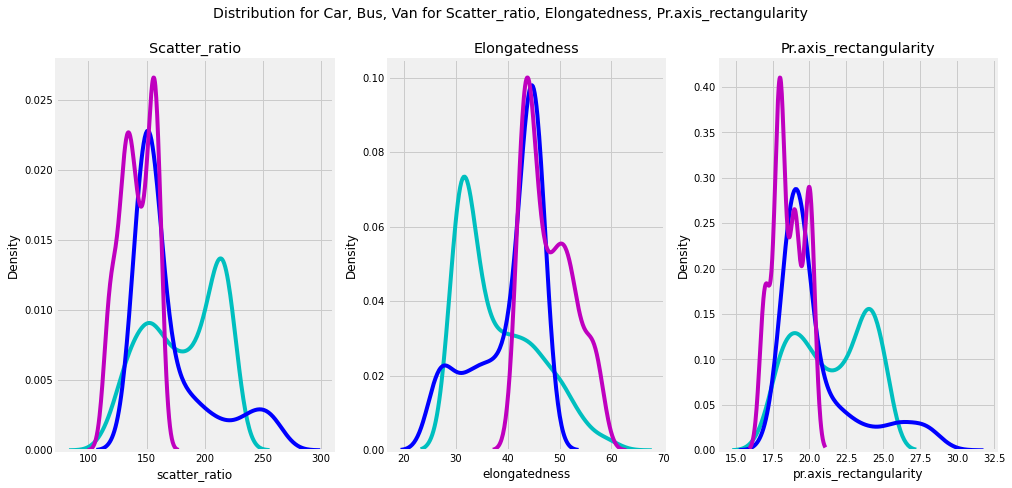

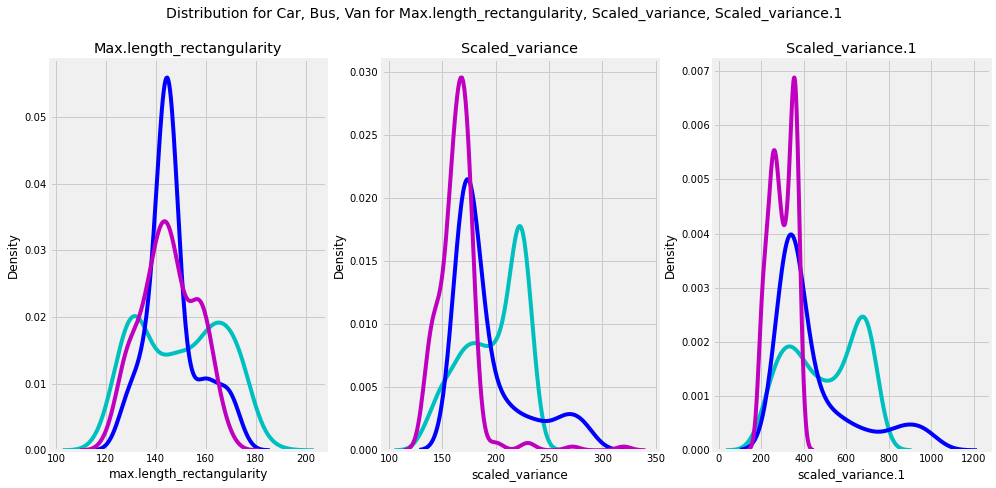

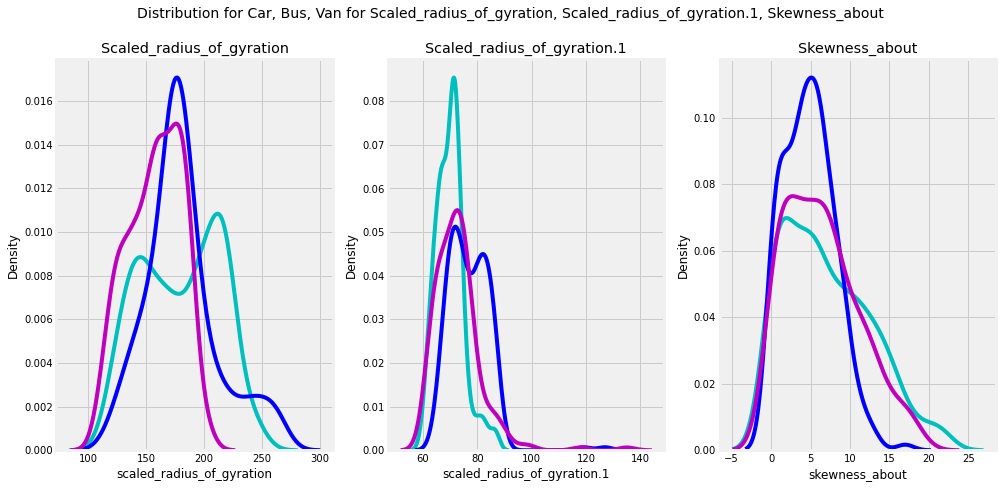

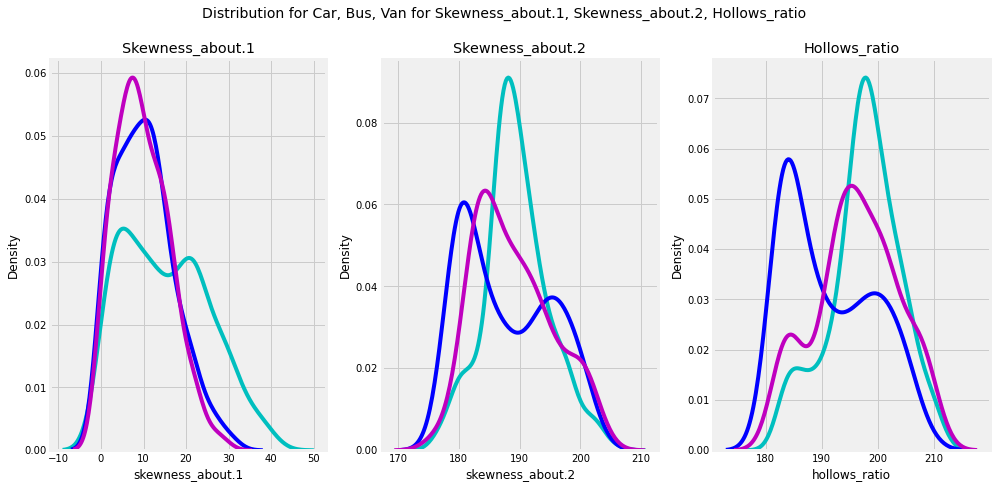

In [15]:
# Distribution of col by target variable
target_plot(vehicle, 'compactness', 'circularity', 'distance_circularity')
target_plot(vehicle, 'radius_ratio', 'pr.axis_aspect_ratio', 'max.length_aspect_ratio')
target_plot(vehicle, 'scatter_ratio', 'elongatedness', 'pr.axis_rectangularity')
target_plot(vehicle, 'max.length_rectangularity', 'scaled_variance', 'scaled_variance.1')
target_plot(vehicle, 'scaled_radius_of_gyration', 'scaled_radius_of_gyration.1', 'skewness_about')
target_plot(vehicle, 'skewness_about.1', 'skewness_about.2', 'hollows_ratio')

<a id='o6'></a>
#### Observation 6 - Comments after checking outliers and distribution
* Used box plot for the features of the vehicle dataframe. Found that `radius_ratio`, `pr.axis_aspect_ratio`, `max.length_aspect_ratio`, `scaled_variance`, `scaled_variance.1`, `scaled_radius_of_gyration.1`, `skewness_about`, `skewness_about.1` columns has outliers. 
* Used quantile method to check outliers in these column. It appears that `scaled_radius_of_gyration.1` has maximum outliers around 15 of them, which represents about 1.77% of number of rows.
* It appears that removing outliers below 25% percentile and above 75% percentile will bring most of the columns to almost normal distribution. That would mean losing around 1.77% of the data.

Let's not to that, **rather replace these outliers with null values and then replace those nulls with median values to avoid losing data.**

<a id='outliers'></a>
### Handling outliers using SimpleImputer

In [16]:
# Removing outliers with upper and lower percentile values being 75 and 25, respectively
vehicle_im = vehicle.copy(deep = True)
outliers_cols = ['radius_ratio', 'pr.axis_aspect_ratio', 'max.length_aspect_ratio', 'scaled_variance', 'scaled_variance.1',
           'scaled_radius_of_gyration.1', 'skewness_about', 'skewness_about.1']

for col in outliers_cols:
    Q3 = vehicle_im[col].quantile(0.75)
    Q1 = vehicle_im[col].quantile(0.25)
    IQR = Q3 - Q1
    upper_lim = Q3 + (1.5 * IQR)
    lower_lim = Q1 - (1.5 * IQR)
    vehicle_im.loc[(vehicle_im[col] < lower_lim) | (vehicle_im[col] > upper_lim), col] = np.nan

print('Column for which outliers where removed with upper and lower percentile values: \n', outliers_cols)

Column for which outliers where removed with upper and lower percentile values: 
 ['radius_ratio', 'pr.axis_aspect_ratio', 'max.length_aspect_ratio', 'scaled_variance', 'scaled_variance.1', 'scaled_radius_of_gyration.1', 'skewness_about', 'skewness_about.1']


In [17]:
vehicle_im.isnull().sum()

compactness                     0
circularity                     0
distance_circularity            0
radius_ratio                    3
pr.axis_aspect_ratio            8
max.length_aspect_ratio        13
scatter_ratio                   0
elongatedness                   0
pr.axis_rectangularity          0
max.length_rectangularity       0
scaled_variance                 1
scaled_variance.1               2
scaled_radius_of_gyration       0
scaled_radius_of_gyration.1    15
skewness_about                 12
skewness_about.1                1
skewness_about.2                0
hollows_ratio                   0
class                           0
dtype: int64

In [18]:
# Using SimpleImputer to fill missing values by median
print('Descriptive Stats before handling outliers: \n', '--'*30)
display(vehicle[outliers_cols].describe().T)

columns = list(vehicle_im.columns)
impute = SimpleImputer(missing_values = np.nan, strategy = 'median', verbose = 1)
vehicle_im = pd.DataFrame(impute.fit_transform(vehicle_im), columns = columns)

print('Descriptive Stats after handling outliers: \n', '--'*30)
display(vehicle_im[outliers_cols].describe().T)
del outliers_cols, vehicle

Descriptive Stats before handling outliers: 
 ------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
radius_ratio,846.00,168.87,33.40,104.00,141.00,167.00,195.00,333.00
pr.axis_aspect_ratio,846.00,61.68,7.88,47.00,57.00,61.00,65.00,138.00
max.length_aspect_ratio,846.00,8.57,4.60,2.00,7.00,8.00,10.00,55.00
scaled_variance,846.00,188.60,31.36,130.00,167.00,179.00,217.00,320.00
scaled_variance.1,846.00,439.31,176.50,184.00,318.25,363.50,586.75,1018.00
scaled_radius_of_gyration.1,846.00,72.44,7.47,59.00,67.00,71.50,75.00,135.00
skewness_about,846.00,6.36,4.90,0.00,2.00,6.00,9.00,22.00
skewness_about.1,846.00,12.60,8.93,0.00,5.00,11.00,19.00,41.00


Descriptive Stats after handling outliers: 
 ------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
radius_ratio,846.00,168.33,32.15,104.00,141.00,167.00,194.75,252.00
pr.axis_aspect_ratio,846.00,61.15,5.61,47.00,57.00,61.00,65.00,76.00
max.length_aspect_ratio,846.00,8.12,2.06,3.00,7.00,8.00,10.00,13.00
scaled_variance,846.00,188.43,31.03,130.00,167.00,179.00,216.75,288.00
scaled_variance.1,846.00,437.79,174.35,184.00,318.25,363.25,586.00,987.00
scaled_radius_of_gyration.1,846.00,71.93,6.16,59.00,67.00,71.00,75.00,87.00
skewness_about,846.00,6.13,4.57,0.00,2.00,5.00,9.00,19.00
skewness_about.1,846.00,12.57,8.88,0.00,5.00,11.00,19.00,40.00


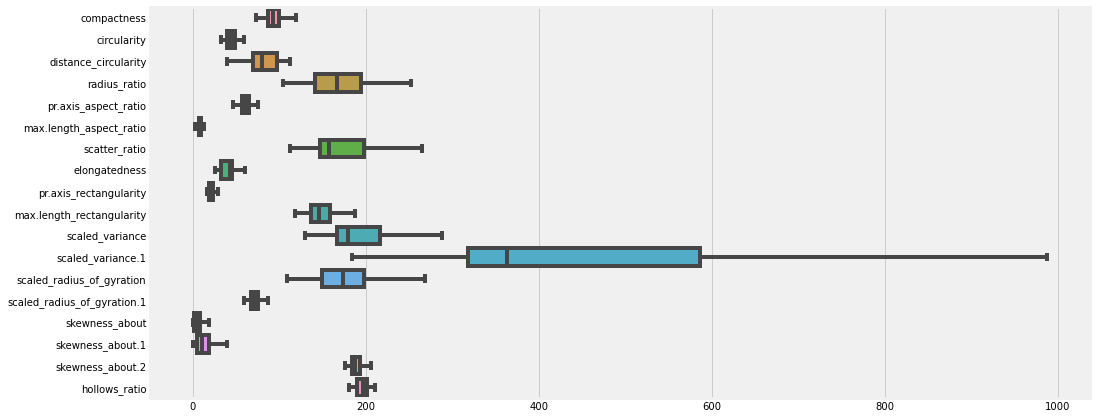

In [19]:
# A quick check to find columns that contain outliers
fig = plt.figure(figsize = (15, 7.2))
ax = sns.boxplot(data = vehicle_im.iloc[:, 0:18], orient = 'h')

<a id='o7'></a>
#### Observation 7 - Comments after checking outliers and distribution
* Instead of removing the outliers, which might have resulted in loss of data, we first replaced the outliers (using IQR method) with nulls and then used SimpleImputer to replace those nulls with median values.
* Again, there's least effect on means and no effect on (ofcourse) median.

<a id='multi'></a>
### Multivariate Visualization
Checking relationship between two or more variables. Includes correlation and scatterplot matrix, checking relation between two variables and target variable.

pr.axis_rectangularity       scatter_ratio                 0.99
scatter_ratio                pr.axis_rectangularity        0.99
scaled_variance.1            scatter_ratio                 0.98
scatter_ratio                scaled_variance.1             0.98
pr.axis_rectangularity       scaled_variance.1             0.97
scaled_variance.1            pr.axis_rectangularity        0.97
scatter_ratio                elongatedness                 0.97
elongatedness                scatter_ratio                 0.97
max.length_rectangularity    circularity                   0.96
circularity                  max.length_rectangularity     0.96
scaled_variance              scatter_ratio                 0.96
scatter_ratio                scaled_variance               0.96
pr.axis_rectangularity       elongatedness                 0.95
elongatedness                pr.axis_rectangularity        0.95
scaled_variance.1            elongatedness                 0.95
elongatedness                scaled_vari

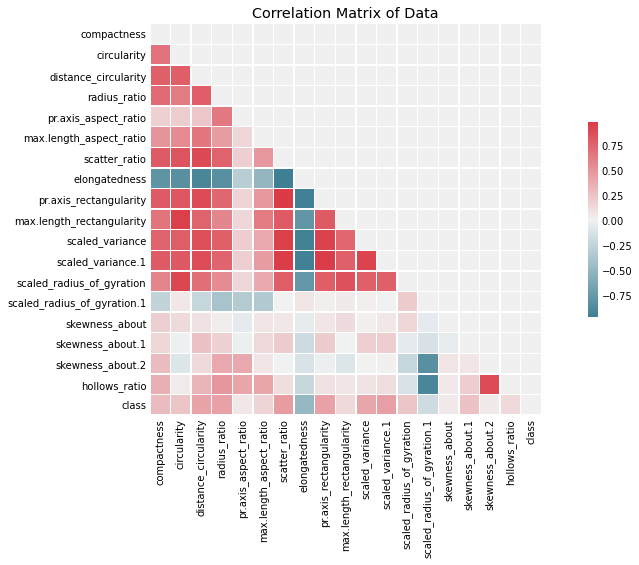

In [20]:
# Correlation matrix for all variables
correlation_matrix(vehicle_im, threshold = 0.8)

In [21]:
# Absolute correlation of independent variables with the target variable
absCorrwithDep = []
allVars = vehicle_im.drop('class', axis = 1).columns

for var in allVars:
    absCorrwithDep.append(abs(vehicle_im['class'].corr(vehicle_im[var])))

display(pd.DataFrame([allVars, absCorrwithDep], index = ['Variable', 'Correlation']).T.\
        sort_values('Correlation', ascending = False))

,Variable,Correlation
7,elongatedness,0.48
6,scatter_ratio,0.46
11,scaled_variance.1,0.45
8,pr.axis_rectangularity,0.44
3,radius_ratio,0.44
2,distance_circularity,0.43
10,scaled_variance,0.42
0,compactness,0.30
15,skewness_about.1,0.27
1,circularity,0.25


<a id='o8'></a>
#### Observation 8 - Correlation matrix
* `scatter_ratio` and `pr.axis_rectangularity`; `scaled_variance.1` and `scatter_ratio`; `pr.axis_rectangularity` and `scaled_variance.1`; `pr.axis_rectangularity` and `scaled_variance.1`; `elongatedness` and `scatter_ratio`; `circularity` and `max.length_rectangularity`; `scaled_variance` and `scatter_ratio`; `elongatedness` and `pr.axis_rectangularity`; `elongatedness` and `scaled_variance.1`; `elongatedness` and `scaled_variance`; `pr.axis_rectangularity`, `scaled_variance` and `scaled_variance.1`; `distance_circularity` and `elongatedness`; `circularity` and `scaled_radius_of_gyration`; `distance_circularity` and `elongatedness`; `scatter_ratio` and `distance_circularity` are correlated with each other with a correlation coeff greater than 0.9.
* `elongatedness`, `scatter_ratio`, `scaled_variance.1`, `pr.axis_rectangularity` and `radius_ratio` are some columns which have relatively strong correlation with the `class` variable.
* Though multicollinearity exists between columns, some of those have a strong influence on the target variable as well. For now lets remove `max.length_rectangularity`, `scaled_variance`, `scaled_radius_of_gyration`, `distance_circularity`, `hollows_ratio` and `skewness_about.2`

In [22]:
vehicle_im.drop(['max.length_rectangularity', 'scaled_variance', 'scaled_radius_of_gyration', 
                 'distance_circularity', 'hollows_ratio', 'skewness_about.2'], axis = 1, inplace = True)

Let's plot pairplot for columns that have a relatively strong correlation with `class` variable...

Indeed highly correlated variables ------------------------------------------------------------


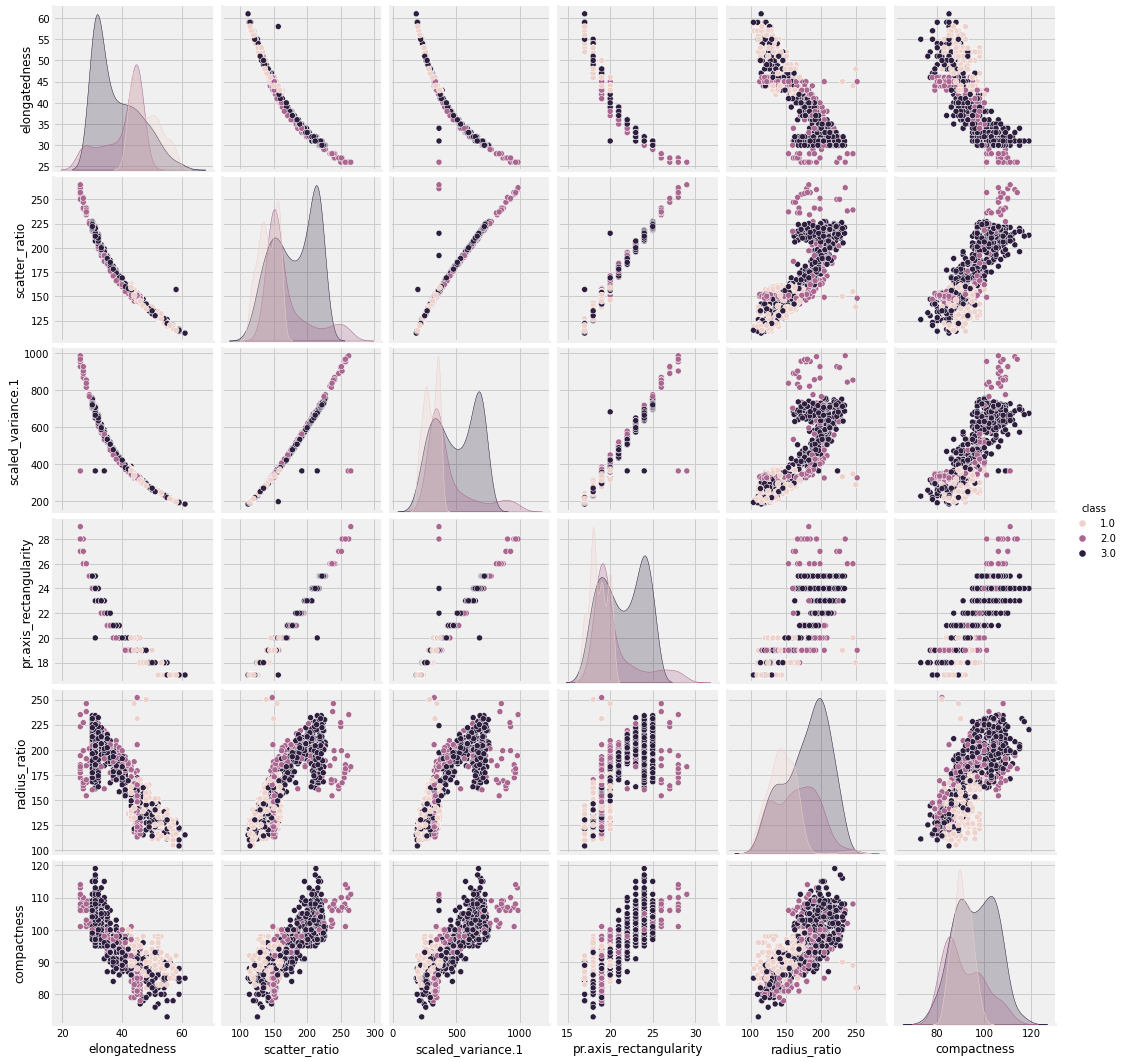

In [23]:
print('Indeed highly correlated variables', '--'*30)
sns.pairplot(vehicle_im[['elongatedness', 'scatter_ratio', 'scaled_variance.1', 
             'pr.axis_rectangularity', 'radius_ratio', 'compactness', 'class']], hue = 'class')

In [24]:
vehicle_im.shape

(846, 13)

In [25]:
# Creating separate variables for features and target
features = vehicle_im.iloc[:, 0:12]; features_list = list(features.columns)
target = vehicle_im['class']

features.shape, target.shape

((846, 12), (846,))

In [26]:
features.head()

,compactness,circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,scaled_variance.1,scaled_radius_of_gyration.1,skewness_about,skewness_about.1
0,95.00,48.00,178.00,72.00,10.00,162.00,42.00,20.00,379.00,70.00,6.00,16.00
1,91.00,41.00,141.00,57.00,9.00,149.00,45.00,19.00,330.00,72.00,9.00,14.00
2,104.00,50.00,209.00,66.00,10.00,207.00,32.00,23.00,635.00,73.00,14.00,9.00
3,93.00,41.00,159.00,63.00,9.00,144.00,46.00,19.00,309.00,63.00,6.00,10.00
4,85.00,44.00,205.00,61.00,8.00,149.00,45.00,19.00,325.00,71.00,9.00,11.00


<a id='pca'></a>
### PCA
Steps performed:
1. As mentioned [here](https://datascience.stackexchange.com/questions/38395/standardscaler-before-and-after-splitting-data) and steps taken [here](https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60), to avoid leakage of data, let's first split the data into train and test set before scaling and performing rest of the PCA steps.
2. Creating a covariance matrix for identifying Principal components
3. Identify eigen values and eigen vector
4. Finding variance and cumulative variance by each eigen vector
5. Use PCA from sklearn and find Principal Components. Transform data to components formed.

In [27]:
# Splitting the data into training and test set in the ratio of 85:25 respectively
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.25, 
                                                    random_state = random_state, shuffle = False)

In [28]:
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)
y_train = y_train.values
y_test = y_test.values

display(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(634, 12)

(634,)

(212, 12)

(212,)

In [29]:
# Covariance matrix
cov_matrix = np.cov(X_train.T)
print('Covariance Matrix \n%s', cov_matrix)

Covariance Matrix 
%s [[ 1.00157978  0.6927466   0.72862246  0.19898718  0.49505746  0.81440645
  -0.78865303  0.81671979  0.81013144 -0.23968157  0.19300214  0.15222827]
 [ 0.6927466   1.00157978  0.64967972  0.21559846  0.56170726  0.8488418
  -0.82596821  0.84312815  0.83012816  0.06020995  0.11617679 -0.01374727]
 [ 0.72862246  0.64967972  1.00157978  0.6458051   0.46182824  0.77614113
  -0.82845233  0.75248537  0.76394977 -0.38576407  0.03171845  0.19228994]
 [ 0.19898718  0.21559846  0.6458051   1.00157978  0.13974833  0.19695357
  -0.29410931  0.16953522  0.1946448  -0.3107984  -0.05839069 -0.02595801]
 [ 0.49505746  0.56170726  0.46182824  0.13974833  1.00157978  0.49596454
  -0.50931992  0.49250771  0.46287865 -0.32635155  0.08945289  0.15872201]
 [ 0.81440645  0.8488418   0.77614113  0.19695357  0.49596454  1.00157978
  -0.97322484  0.99049017  0.98555786  0.00793151  0.04716969  0.2125568 ]
 [-0.78865303 -0.82596821 -0.82845233 -0.29410931 -0.50931992 -0.97322484
   1.001579

In [30]:
# Eigen values and vector
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)
print('Eigen Vectors \n%s', eig_vecs)
print('\n Eigen Values \n%s', eig_vals)

Eigen Vectors 
%s [[-3.39450715e-01  2.36357770e-02 -1.63175268e-01 -6.33209676e-02
  -1.45937709e-02  3.85496746e-01  8.02007929e-01 -2.06839187e-01
   9.52114113e-03 -2.79550123e-02  1.33738935e-01 -8.51456120e-04]
 [-3.39576130e-01 -1.76359038e-01  3.31498572e-02 -1.88619678e-01
   1.58754055e-01 -2.27806785e-01 -2.50134455e-01 -8.17630172e-01
   2.30219364e-02 -3.24498995e-02  2.09070144e-02 -8.18780263e-02]
 [-3.39786015e-01  3.05768414e-01  1.68414061e-01 -4.04368461e-02
  -1.67741829e-01  3.73521106e-02 -7.12117053e-02  1.47234052e-01
   1.40364519e-02 -2.04231985e-02 -2.11786378e-01 -8.11975143e-01]
 [-1.32048433e-01  5.17895579e-01  4.65277587e-01 -2.26573804e-01
  -3.15478527e-01 -4.09971025e-01  1.87407805e-01 -2.88899782e-02
  -1.92555573e-02  3.03940544e-02  2.26065837e-02  3.75717404e-01]
 [-2.36731239e-01  1.72203564e-01 -2.89579241e-01  1.66499147e-02
   6.73394380e-01 -5.20849315e-01  1.74163583e-01  2.70023726e-01
  -4.90218338e-04 -2.67872955e-02 -3.44032638e-02 -1.6

In [31]:
# Cumulative variance explained
tot = sum(eig_vals)
var_exp = [(i /tot) * 100 for i in sorted(eig_vals, reverse = True)]
cum_var_exp = np.cumsum(var_exp)

print('Cumulative Variance Explained', cum_var_exp)

Cumulative Variance Explained [ 54.37087735  67.26948354  76.54136817  85.49773096  91.78218978
  95.9440383   97.65085431  98.9204619   99.43293559  99.78135812
  99.95111763 100.        ]


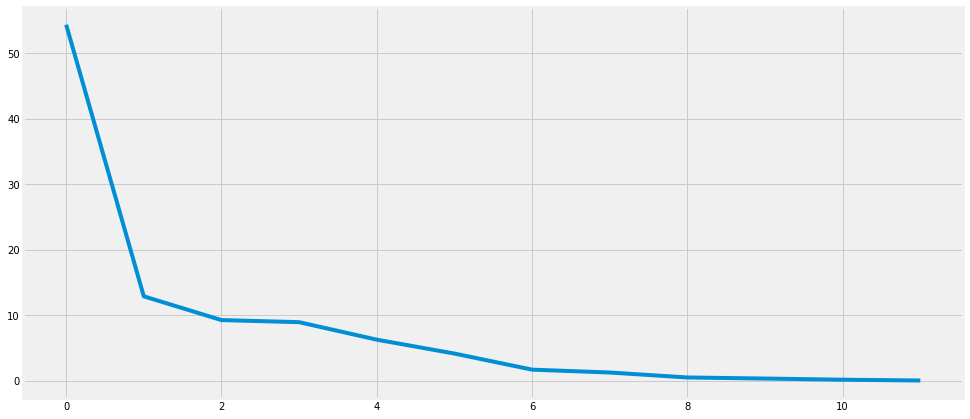

In [32]:
plt.figure(figsize = (15 , 7.2))
plt.plot(var_exp)

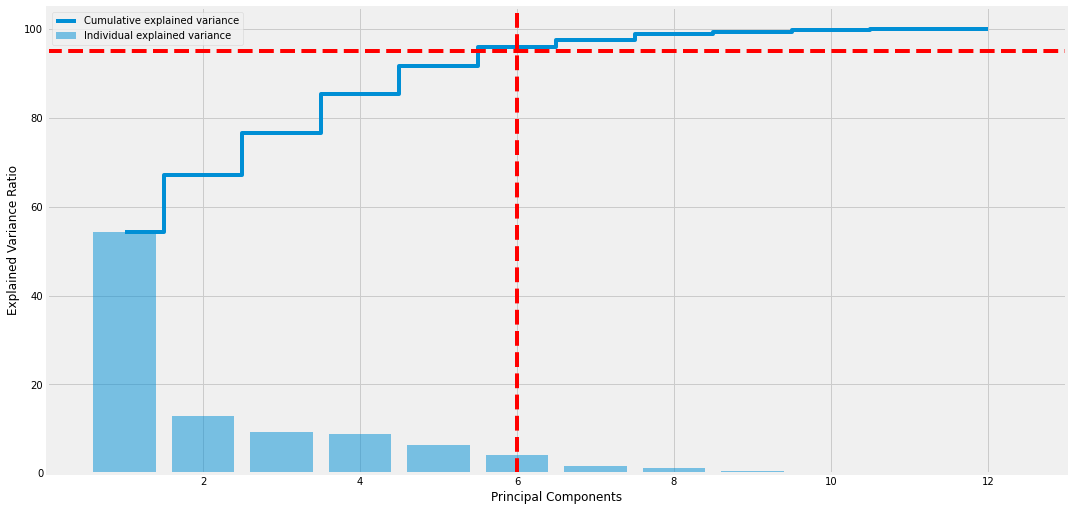

In [33]:
# Ploting 
plt.figure(figsize = (15 , 7.2))
plt.bar(range(1, eig_vals.size + 1), var_exp, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.step(range(1, eig_vals.size + 1), cum_var_exp, where = 'mid', label = 'Cumulative explained variance')
plt.axhline(y = 95, color = 'r', linestyle = '--')
plt.axvline(x = 6, color = 'r', linestyle = '--')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

<a id='o9'></a>
#### Observation 8 - PCA 
* Visually we can observe that their is steep drop in variance explained with increase in number of PC's.
* We will proceed with 6 components here which covers more than 95% of variance.

In [34]:
# Reducing the dimensions from 12 to 6
pca = PCA(n_components = 6, random_state = random_state)
pca.fit(X_train)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.fit_transform(X_test)
display(X_train_reduced.shape, X_test_reduced.shape)

(634, 6)

(212, 6)

In [35]:
pca.components_

array([[ 0.34009463,  0.33794945,  0.33503446,  0.13041569,  0.23652898,
         0.38048316, -0.38018014,  0.37579804,  0.3752845 , -0.05863032,
         0.05802983,  0.08216775],
       [-0.01708559,  0.18133851, -0.32574657, -0.54502345, -0.19833762,
         0.15551679, -0.04657311,  0.18064402,  0.13444857,  0.64541435,
         0.165809  ,  0.05665432],
       [ 0.06575121,  0.17648847, -0.03327224, -0.01308773,  0.12490053,
        -0.05935091,  0.04297934, -0.06143859, -0.06308507, -0.09867145,
         0.66276782, -0.6967989 ],
       [ 0.2112849 , -0.13502957, -0.1346522 , -0.37483765,  0.31520721,
        -0.0682641 ,  0.10682439, -0.04298389, -0.0485113 , -0.36467931,
         0.45724618,  0.56284827],
       [-0.05721052, -0.13484345,  0.19649251,  0.4550835 , -0.54315451,
         0.00282427, -0.04349429, -0.02006966,  0.02745604,  0.1809912 ,
         0.54106651,  0.33052979],
       [ 0.37871695, -0.29415461,  0.06660237, -0.36394537, -0.61434687,
         0.09278887, -

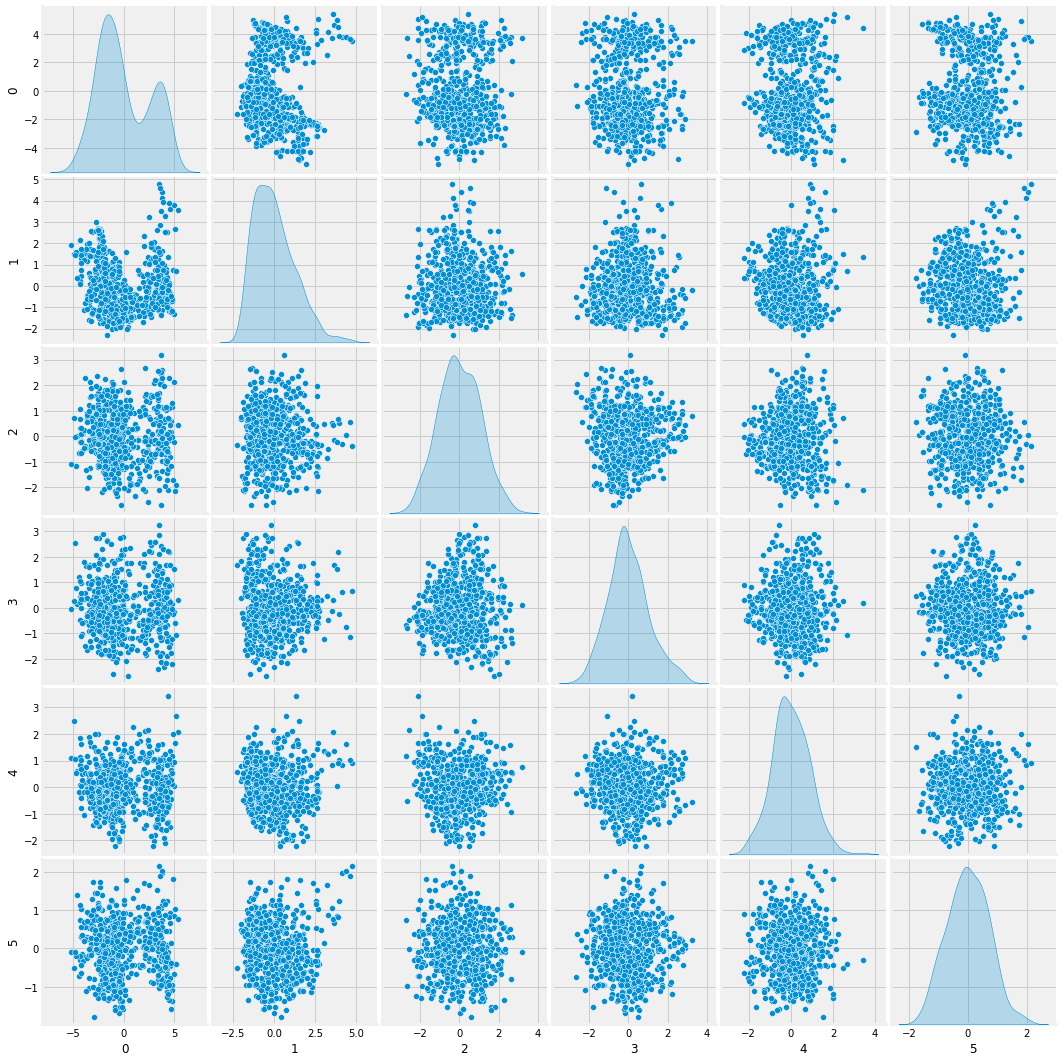

In [36]:
# Pairplot after dimension reduction
sns.pairplot(pd.DataFrame(X_train_reduced), diag_kind = 'kde')

In [37]:
# Creating a dimension reduced with features and target
df_train = pd.DataFrame(X_train_reduced).join(pd.DataFrame(y_train, columns = ['class']), how = 'left', sort = False)
df_test = pd.DataFrame(X_test_reduced).join(pd.DataFrame(y_test, columns = ['class']), how = 'left', sort = False)
df_train.shape, df_test.shape

((634, 7), (212, 7))

<a id='o9'></a>
#### Observation 9 - Dimensionality Reduction 
* After dimensionality reduction using PCA our attributes have become independent with no correlation among themselves

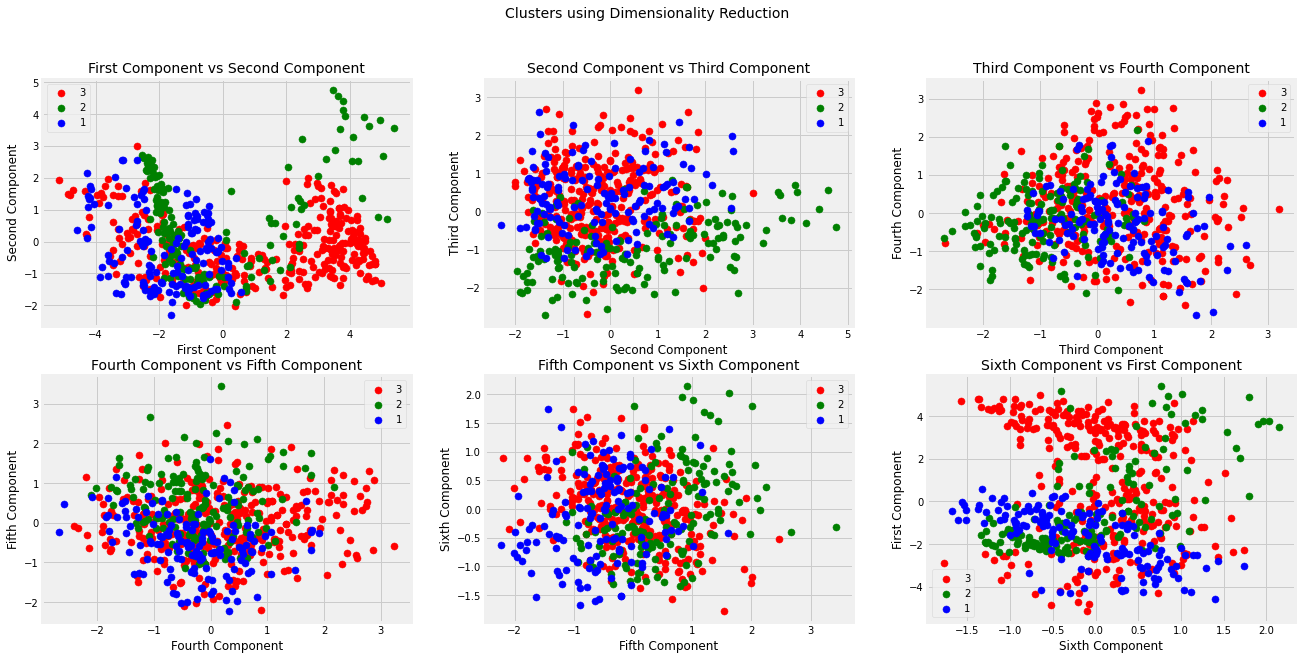

In [38]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize = (20, 10))
f.suptitle('Clusters using Dimensionality Reduction', fontsize = 14)

pca_plots(df_train, 0, 1, 'First Component', 'Second Component', ax1)
pca_plots(df_train, 1, 2, 'Second Component', 'Third Component', ax2)
pca_plots(df_train, 2, 3, 'Third Component', 'Fourth Component', ax3)
pca_plots(df_train, 3, 4, 'Fourth Component', 'Fifth Component', ax4)
pca_plots(df_train, 4, 5, 'Fifth Component', 'Sixth Component', ax5)
pca_plots(df_train, 5, 0, 'Sixth Component', 'First Component', ax6)

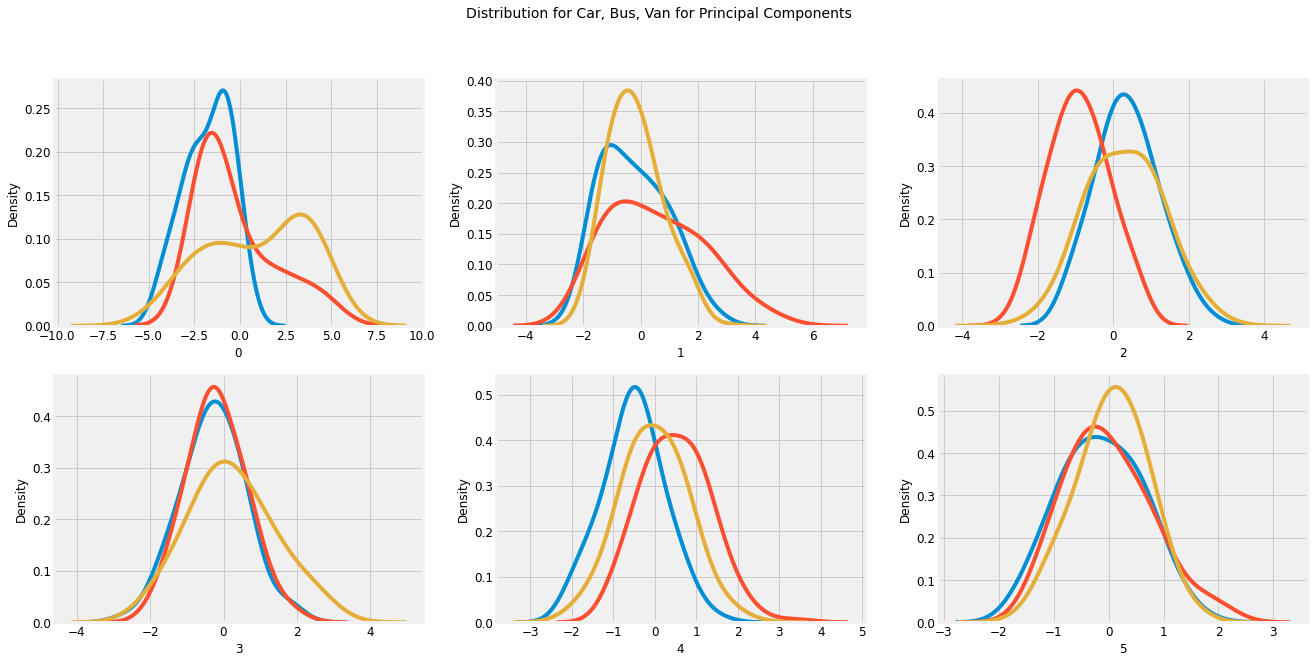

In [39]:
features = [f for f in df_train.columns if f not in ['class']]

i = 0
t1 = df_train[df_train['class'] == 1]
t2 = df_train[df_train['class'] == 2]
t3 = df_train[df_train['class'] == 3]

fig, ax = plt.subplots(2, 3, figsize = (20, 10))
fig.suptitle('Distribution for Car, Bus, Van for Principal Components', fontsize = 14)

for feature in features:
    i += 1
    plt.subplot(2, 3, i)
    sns.kdeplot(t1[feature], bw = 0.5, label = 'Van')
    sns.kdeplot(t2[feature], bw = 0.5, label = 'Bus')
    sns.kdeplot(t3[feature], bw = 0.5, label = 'Car')
    plt.xlabel(feature, fontsize = 12)
    locs, labels = plt.xticks()
    plt.tick_params(axis = 'both', which = 'major', labelsize = 12)
plt.show()

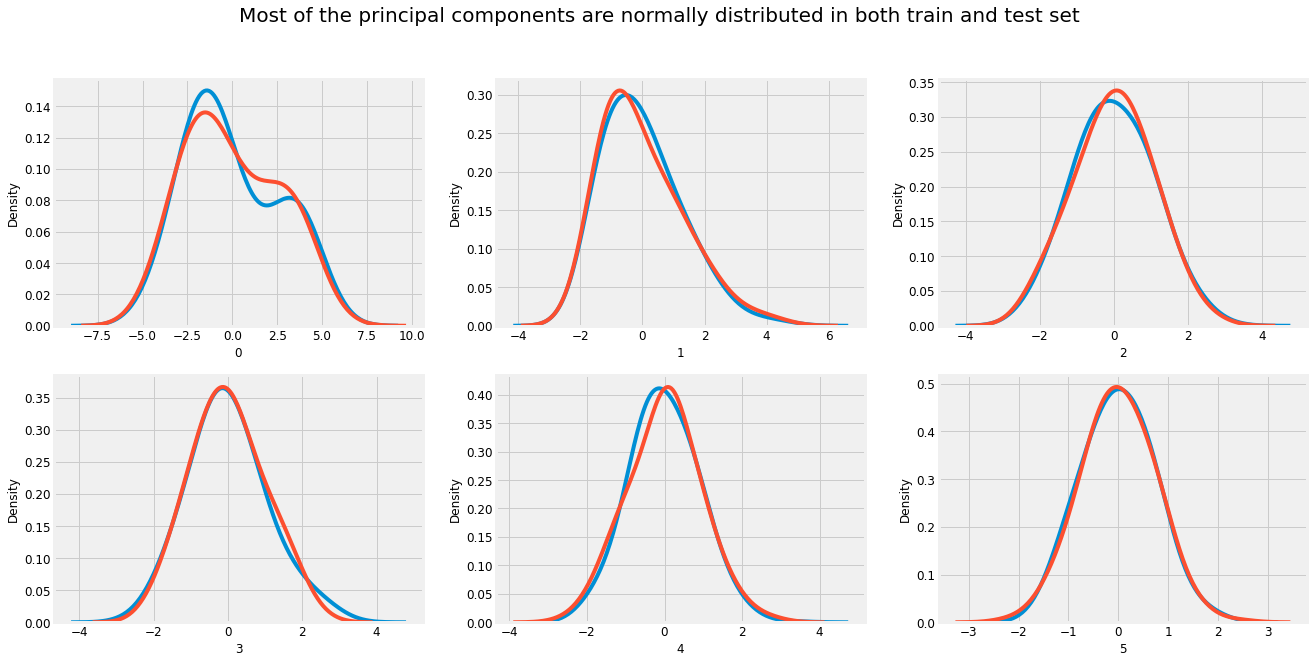

In [40]:
features = [f for f in df_train.columns if f not in ['class']]

i = 0
ttr = df_train.drop(['class'], axis = 1)
tte = df_test.drop(['class'], axis = 1)

fig, ax = plt.subplots(2, 3, figsize = (20, 10))
fig.suptitle('Most of the principal components are normally distributed in both train and test set', fontsize = 20)

for feature in features:
    i += 1
    plt.subplot(2, 3, i)
    sns.kdeplot(ttr[feature], bw = 0.5, label = 'Train')
    sns.kdeplot(tte[feature], bw = 0.5, label = 'Test')
    plt.xlabel(feature, fontsize = 12)
    locs, labels = plt.xticks()
    plt.tick_params(axis = 'both', which = 'major', labelsize = 12)
plt.show();

<a id='model'></a>
### Modelling
As mentioned in the list of tasks, use Naive Bayes and support vector machines. Use grid search for SVC (try C values - 0.01, 0.05, 0.5, 1 and kernel = linear, rbf) and find out the best hyper parameters and do cross validation to find the accuracy.

LR: 0.771494 (0.038185)
KNN: 0.847492 (0.026373)
NB: 0.759678 (0.053360)
SVC: 0.899640 (0.040713)
CART: 0.794529 (0.026926)
RF: 0.873681 (0.054698)


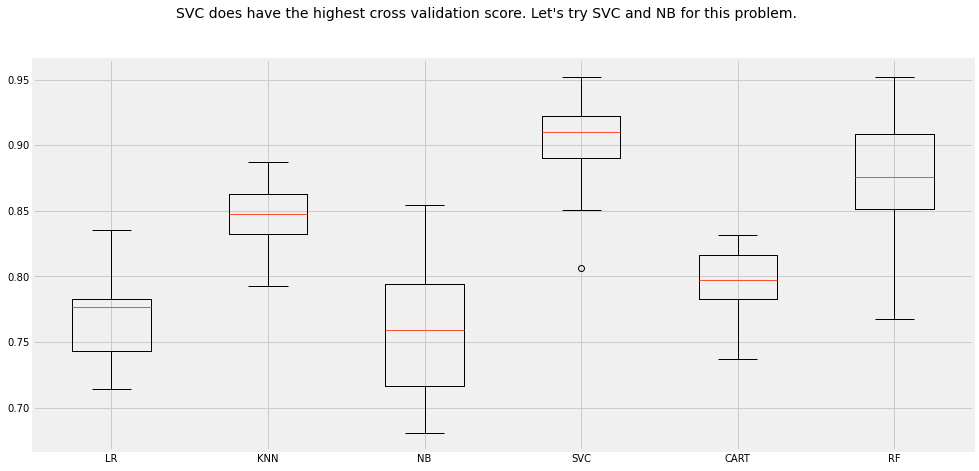

In [41]:
# Compare different models on the principal components
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVC', SVC()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))

# evaluate each model in turn
results = []
names = []
scoring = 'f1_macro'
for name, model in models:
    skf = StratifiedKFold(n_splits = 10, random_state = random_state,shuffle=True)
    cv_results = cross_val_score(model, X_train_reduced, y_train, cv = skf, scoring = scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = plt.figure(figsize = (15, 7.2))
fig.suptitle(f'SVC does have the highest cross validation score. Let\'s try SVC and NB for this problem.', fontsize = 14)
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [42]:
# Naive Bayes Model -- Principal Components
NB = GaussianNB()
NB.fit(X_train_reduced, y_train)

print('Naive Bayes Classifier Scores\n\n')
print('NB accuracy for train set: {0:.3f}'.format(NB.score(X_train_reduced, y_train)))
print('NB accuracy for test set: {0:.3f}'.format(NB.score(X_test_reduced, y_test)))

y_true, y_pred = y_test, NB.predict(X_test_reduced)

# Cross Validation Score
skf = StratifiedKFold(n_splits = 10, random_state = random_state,shuffle=True)
nb_score = cross_val_score(NB, X_train_reduced, y_train, cv = skf, scoring = scoring)
print('NB cross validation training score: ', round(nb_score.mean(), 3).astype(str))

# Accuracy Score
auc = accuracy_score(y_true, y_pred)
print('\nAccuracy Score:\n', auc.round(3))

# Classification Report
print('\n{}'.format(classification_report(y_true, y_pred)))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print('\nConfusion Matrix:\n', cm)

Naive Bayes Classifier Scores


NB accuracy for train set: 0.798
NB accuracy for test set: 0.675
NB cross validation training score:  0.76

Accuracy Score:
 0.675

              precision    recall  f1-score   support

         1.0       0.58      0.67      0.62        49
         2.0       0.60      0.53      0.56        53
         3.0       0.76      0.75      0.75       110

    accuracy                           0.67       212
   macro avg       0.64      0.65      0.64       212
weighted avg       0.68      0.67      0.67       212


Confusion Matrix:
 [[33  3 13]
 [12 28 13]
 [12 16 82]]


In [43]:
# SVC with hyperparameter tuning -- Principal Components
svc = SVC(random_state = random_state)

params = {'C': [0.01, 0.05, 0.5, 1], 'kernel': ['linear', 'rbf']}

skf = StratifiedKFold(n_splits = 10, random_state = random_state,shuffle=True)
grid_svc = GridSearchCV(svc, param_grid = params, n_jobs = -1, cv = skf)

grid_svc.fit(X_train_reduced, y_train)

print('SVC Scores with Hyperparameter Tuning\n\n')
print('Best Hyper Parameters are: ', grid_svc.best_params_)
print('Best Score is: ', grid_svc.best_score_.round(3))

print('SVC accuracy for train set: {0:.3f}'.format(grid_svc.score(X_train_reduced, y_train)))
print('SVC accuracy for test set: {0:.3f}'.format(grid_svc.score(X_test_reduced, y_test)))

y_true, y_pred = y_test, grid_svc.predict(X_test_reduced)

# Cross Validation Score
grid_svc_score = cross_val_score(grid_svc, X_train_reduced, y_train, cv = skf, scoring = scoring)
print('SVC cross validation training score: ', round(grid_svc_score.mean(), 3).astype(str))

# Accuracy Score
auc = accuracy_score(y_true, y_pred)
print('\nAccuracy Score:\n', auc.round(3))

# Classification Report
print('\n{}'.format(classification_report(y_true, y_pred)))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print('\nConfusion Matrix:\n', cm)

SVC Scores with Hyperparameter Tuning


Best Hyper Parameters are:  {'C': 1, 'kernel': 'rbf'}
Best Score is:  0.907
SVC accuracy for train set: 0.918
SVC accuracy for test set: 0.778
SVC cross validation training score:  0.9

Accuracy Score:
 0.778

              precision    recall  f1-score   support

         1.0       0.65      0.73      0.69        49
         2.0       0.77      0.77      0.77        53
         3.0       0.85      0.80      0.82       110

    accuracy                           0.78       212
   macro avg       0.76      0.77      0.76       212
weighted avg       0.78      0.78      0.78       212


Confusion Matrix:
 [[36  2 11]
 [ 7 41  5]
 [12 10 88]]


In [44]:
# SVC with hyperparameter tuning -- Original Features
svc = SVC(random_state = random_state)

params = {'C': [0.01, 0.05, 0.5, 1], 'kernel': ['linear', 'rbf']}

skf = StratifiedKFold(n_splits = 10)
grid_svc_f = GridSearchCV(svc, param_grid = params, n_jobs = -1, cv = skf)

grid_svc_f.fit(X_train, y_train)

print('SVC Scores with Hyperparameter Tuning\n\n')
print('Best Hyper Parameters are: ', grid_svc_f.best_params_)
print('Best Score is: ', grid_svc_f.best_score_.round(3))

print('SVC accuracy for train set: {0:.3f}'.format(grid_svc_f.score(X_train, y_train)))
print('SVC accuracy for test set: {0:.3f}'.format(grid_svc_f.score(X_test, y_test)))

y_true, y_pred = y_test, grid_svc_f.predict(X_test)

# Cross Validation Score
grid_svc_f_score = cross_val_score(grid_svc_f, X_train, y_train, cv = skf, scoring = scoring)
print('SVC cross validation training score: ', round(grid_svc_f_score.mean(), 3).astype(str))

# Accuracy Score
auc = accuracy_score(y_true, y_pred)
print('\nAccuracy Score:\n', auc.round(3))

# Classification Report
print('\n{}'.format(classification_report(y_true, y_pred)))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print('\nConfusion Matrix:\n', cm)

SVC Scores with Hyperparameter Tuning


Best Hyper Parameters are:  {'C': 1, 'kernel': 'rbf'}
Best Score is:  0.924
SVC accuracy for train set: 0.950
SVC accuracy for test set: 0.929
SVC cross validation training score:  0.921

Accuracy Score:
 0.929

              precision    recall  f1-score   support

         1.0       0.92      0.90      0.91        49
         2.0       0.91      0.96      0.94        53
         3.0       0.94      0.93      0.94       110

    accuracy                           0.93       212
   macro avg       0.92      0.93      0.93       212
weighted avg       0.93      0.93      0.93       212


Confusion Matrix:
 [[ 44   1   4]
 [  0  51   2]
 [  4   4 102]]


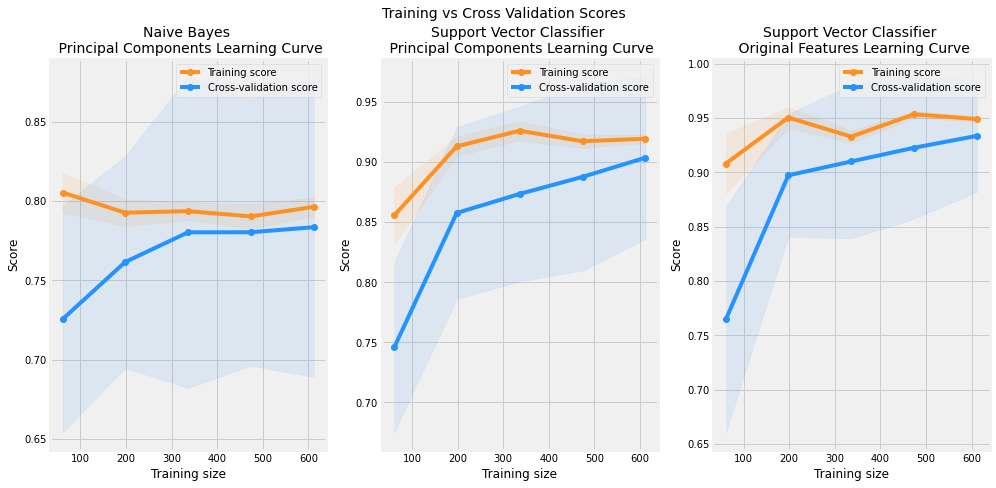

In [45]:
# Plot training vs cross validation scores
cv = StratifiedKFold(n_splits = 30, random_state = random_state,shuffle=True)

f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize = (15, 7.2))
f.suptitle('Training vs Cross Validation Scores', fontsize = 14)

plot_learning_curve(NB, X_train_reduced, y_train, cv = cv, n_jobs = 1, ax = ax1,
                    name = 'Naive Bayes \n Principal Components Learning Curve')

plot_learning_curve(grid_svc, X_train_reduced, y_train, cv = cv, n_jobs = 1, ax = ax2, 
                    name = 'Support Vector Classifier \n Principal Components Learning Curve')

plot_learning_curve(grid_svc_f, X_train, y_train, cv = cv, n_jobs = 1, ax = ax3,
                    name = 'Support Vector Classifier \n Original Features Learning Curve')

<a id='conclusion'></a>
### Conclusion

We used correlation matrix and checked the relation of each feature with the `class` column to reduce the number of features in the dataset to 12 from 18.

PCA being a statistical technique to <span class="mark">reduce the dimensionality</span> of the data by the selecting the most important features that captures maximum information about the dataset, does the task here. <span class="mark">Here we've reduced the dimension from 12 to 6 and selected those which explained 95% variance. Doing that it removes the correlated features as well, which we saw in the scatterplot before and after PCA.</span> 

However, some of the limitations which are clearly seen in this use case are: after implementing PCA on the dataset, we saw features getting converted into principal components. Principal components are the linear combination of original features. <span class="mark">This makes the features less interpretable.</span> Additionally, we know that one of limitation of PCA is it assumes linearity i.e. principal components are a linear combinations of the original features, which if not true will not give a sensible results.[.](https://www.quora.com/What-are-the-disadvantages-of-a-PCA)

<span class="mark">We then applied Naive Bayes and Support Vector Classifier on the reduced features (dimensions) and got an accuracy of 67.5% and 78.3% respectively and precision (macro) score of 64% and 76% respectively. Recall (macro) score for the same was 65% and 77% respectively. We then also applied SVC on the 12 actual features (with interpretability) and saw an accuracy score of 92.9%, precision (macro) score of 92% and recall (macro) score of 93%, which is a way better score then SVC when applied on principal components.</span>

**Shape of dataset we were dealing with was 846 rows and 12 features + 1 class column. Effect of PCA can be more useful in large datasets with more features.**

Based on learning curve, we can conclude that for Naive Bayes with principal components, both training and validation scores are volatile, however the validation score almost flattens beyond a training size of ~330. For SVC with principal components and original features, both training and validation scores increases with the increase in size of the dataset, which would mean the scores can be further increases with more training samples. Howevver, the gap between training and validation score for SVC with principal component is higher than then the others.